Created on Tue Nov  7 16:59:14 2023

@author: Santiago D'hers

Use:

- This script will train AI models to identify exploration using mouse and object position

Requirements:

- The position.csv files processed by 1-Manage_H5.py
- Labeled data for the position files (to train the model)

or

- Access to the file colabeled_data.csv, where we can find:
    - Position and labels for representative exploration events
    - It includes the labels of 5 viewers (so far)

In [40]:
import h5py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
import random
import datetime

import joblib

# from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, classification_report, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional, Lambda, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
# from tensorflow.keras.regularizers import l2

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [41]:
desktop = 'C:/Users/dhers/Desktop'
STORM_folder = os.path.join(desktop, 'STORM/models')

colabels_file = os.path.join(STORM_folder, 'colabels.csv')
colabels = pd.read_csv(colabels_file)

bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body']
objects = ['obj']

train_with_average = True # If False, it trains with all the labels separately
make_discrete = False # If False, labels are float (not 0 and 1)
save_data = True # if True, the data processed will be saved with today's date

use_saved_data = False # if True, we use the dataframe processed previously
if use_saved_data:
    saved_data = r'c:\Users\dhers\Desktop\STORM\models\training_data\training_data_2024-10-22.h5' # Select the data you want to rescue

# Get the start time
start_time = datetime.datetime.now()

In [42]:
def prepare_positions_and_labels(colabels, train_with_average = True):

    # The labels for left and right exploration are on the rest of the columns, we need to extract them
    position = colabels.filter(regex='_x|_y').filter(regex='^(?!.*tail)').copy()
                            
    lblr_A = colabels.filter(regex='Marian').copy()
    lblr_B = colabels.filter(regex='Agus').copy()
    lblr_C = colabels.filter(regex='Santi').copy()
    lblr_D = colabels.filter(regex='Guille').copy()
    lblr_E = colabels.filter(regex='Myself').copy()

    labelers = [lblr_A, lblr_B, lblr_C, lblr_D, lblr_E]

    if train_with_average:
        # Concatenate the dataframes along the columns axis (axis=1) and calculate the mean of each row
        combined_df = pd.concat(labelers, axis=1)
        avrg = pd.DataFrame(combined_df.mean(axis=1), columns=['mean'])

        # Apply median filter
        avrg['med_filt'] = signal.medfilt(avrg['mean'], kernel_size = 3)

        # Gaussian kernel
        gauss_kernel = signal.windows.gaussian(3, 0.6)
        gauss_kernel = gauss_kernel / sum(gauss_kernel)

        # Pad the median filtered data to mitigate edge effects
        pad_width = (len(gauss_kernel) - 1) // 2
        padded = np.pad(avrg['med_filt'], pad_width, mode='edge')

        # Apply convolution
        smooth = signal.convolve(padded, gauss_kernel, mode='valid')

        # Trim the padded edges to restore original length
        avrg['smooth'] = smooth[:len(avrg['mean'])]

        # Apply sigmoid function to keep values between 0 and 1
        avrg['labels'] = round(1 / (1 + np.exp(-12*(avrg['smooth']-0.5))), 2)

        ready_data = pd.concat([position, avrg['labels']], axis = 1)

    else:
        # Join position with all the labels separately
        concatenated_position = pd.concat([position] * len(labelers), ignore_index=True)
        concatenated_labelers = pd.concat(labelers, ignore_index=True)
        ready_data = pd.concat([concatenated_position, concatenated_labelers], axis = 1)

    return ready_data, labelers

# Prepare the data
ready_data, labelers = prepare_positions_and_labels(colabels)

In [43]:
def recenter(df, point, bodyparts):
    # Create a copy of the original dataframe
    df_copy = df.copy()
    bodypart_columns = []
    
    for bodypart in bodyparts:
        # Subtract point_x from columns ending in _x
        x_cols = [col for col in df_copy.columns if col.endswith(f'{bodypart}_x')]
        df_copy[x_cols] = df_copy[x_cols].apply(lambda col: col - df_copy[f'{point}_x'])
        
        # Subtract point_y from columns ending in _y
        y_cols = [col for col in df_copy.columns if col.endswith(f'{bodypart}_y')]
        df_copy[y_cols] = df_copy[y_cols].apply(lambda col: col - df_copy[f'{point}_y'])
        
        # Collect bodypart columns
        bodypart_columns.extend(x_cols)
        bodypart_columns.extend(y_cols)
        
    return df_copy[bodypart_columns]


def reshape(df):
    reshaped_df = []
    
    # Iterate over each row index in the DataFrame
    for i in range(len(df)):
        # Determine which indices to include for reshaping
        indices_to_include = [
            max(0, i - 6),  # i - 6, ensure it's not negative
            max(0, i - 3),  # i - 3, ensure it's not negative
            max(0, i - 1),  # i - 1, ensure it's not negative
            i,              # current index
            min(len(df) - 1, i + 1),  # i + 1, ensure it's not out of bounds
            min(len(df) - 1, i + 3),  # i + 3, ensure it's not out of bounds
            min(len(df) - 1, i + 6)   # i + 6, ensure it's not out of bounds
        ]
        
        # Append the rows using the calculated indices
        reshaped_df.append(df.iloc[indices_to_include])
    
    return reshaped_df


def focus(df, column_to_filter = 'labels', distance = 25):

    # Extract the column of interest
    column_of_interest = df.loc[:, column_to_filter]

    print(f'Starting with {len(column_of_interest)} rows')

    # Find the indices of the non-zero rows in the column
    non_zero_indices = column_of_interest[column_of_interest != 0].index

    # Create a boolean mask to keep rows that are within 'distance' rows of a non-zero row
    mask = pd.Series(False, index=df.index)

    for idx in non_zero_indices:
        # Mark rows within 'distance' rows before and after the non-zero row
        lower_bound = max(0, idx - distance)
        upper_bound = min(len(df) - 1, idx + distance)
        mask[lower_bound:upper_bound + 1] = True

    # Filter the dataframe using the mask
    df_filtered = df[mask]

    # Optional: Reset index if you want a clean dataframe without gaps in the indices
    df_filtered.reset_index(drop=True, inplace=True)
    
    print(f"Reduced to {len(df_filtered)} rows. Number of exploration rows: {len(non_zero_indices)}")

    return df_filtered

In [44]:
ready_data_focus = focus(ready_data, distance = 50)

Starting with 167012 rows
Reduced to 63760 rows. Number of exploration rows: 17195


In [45]:
def prepare_training_data(df, obj = 'obj', bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body'], y_col = 'labels'):
    
    # Group the DataFrame by the values in the first column
    groups = df.groupby(df[f'{obj}_x'])
    
    # Split the DataFrame into multiple DataFrames and labels
    final_dataframes = {}
    wide_dataframes = {}
    
    for category, group in groups:

        recentered_data = recenter(group, obj, bodyparts)
        labels = group[f'{y_col}']

        final_dataframes[category] = {'position': recentered_data, 'labels': labels}

        reshaped_data = reshape(recentered_data)
        wide_dataframes[category] = {'position': reshaped_data, 'labels': labels}
        
    # Get a list of the keys (categories)
    keys = list(wide_dataframes.keys())
    
    # Shuffle the keys
    np.random.shuffle(keys)
    
    # Calculate the lengths for each part
    len_val = len(keys) * 15 // 100
    len_test = len(keys) * 15 // 100
    
    # Use slicing to divide the list
    val_keys = keys[:len_val]
    test_keys = keys[len_val:(len_val + len_test)]
    train_keys = keys[(len_val + len_test):]
    
    # Initialize empty lists to collect dataframes
    X_train_wide = []
    X_test_wide = []
    X_val_wide = []

    X_train = []
    X_test = []
    X_val = []

    y_train = []
    y_test = []
    y_val = []
    
    # first the simple data 
    for key in train_keys:
        X_train_wide.append(wide_dataframes[key]['position'])
        X_train.append(final_dataframes[key]['position'])
        y_train.append(final_dataframes[key]['labels'])
    for key in test_keys:
        X_test_wide.append(wide_dataframes[key]['position'])
        X_test.append(final_dataframes[key]['position'])
        y_test.append(final_dataframes[key]['labels'])
    for key in val_keys:
        X_val_wide.append(wide_dataframes[key]['position'])
        X_val.append(final_dataframes[key]['position'])
        y_val.append(final_dataframes[key]['labels'])
    
    X_train_wide = np.concatenate(X_train_wide, axis=0)
    X_test_wide = np.concatenate(X_test_wide, axis=0)
    X_val_wide = np.concatenate(X_val_wide, axis=0)

    X_train = np.concatenate(X_train, axis=0)
    X_test = np.concatenate(X_test, axis=0)
    X_val = np.concatenate(X_val, axis=0)
        
    y_train = np.concatenate(y_train, axis=0)
    y_test = np.concatenate(y_test, axis=0)
    y_val = np.concatenate(y_val, axis=0)
    
    return X_train_wide, X_train, y_train, X_test_wide, X_test, y_test, X_val_wide, X_val, y_val

In [46]:
if use_saved_data:
    # Load arrays
    with h5py.File(saved_data, 'r') as hf:
        X_test = hf['X_test'][:]
        y_test = hf['y_test'][:]
        X_val = hf['X_val'][:]
        y_val = hf['y_val'][:]
        X_train = hf['X_train'][:]
        y_train = hf['y_train'][:]
        X_test_wide = hf['X_test_wide'][:]
        X_val_wide = hf['X_val_wide'][:]
        X_train_wide = hf['X_train_wide'][:]
        
    print("Data is ready to train")

else:
    X_train_wide, X_train, y_train, X_test_wide, X_test, y_test, X_val_wide, X_val, y_val = prepare_training_data(ready_data_focus)
    
    # Print the sizes of each set
    print(f"Training set size: {len(X_train)} samples")
    print(f"Validation set size: {len(X_val)} samples")
    print(f"Testing set size: {len(X_test)} samples")
    print(f"Total samples: {len(X_train)+len(X_val)+len(X_test)}")

    if save_data:
        # Save arrays
        with h5py.File(os.path.join(STORM_folder, f'training_data/training_data_{start_time.date()}.h5'), 'w') as hf:
            hf.create_dataset('X_test', data=X_test)
            hf.create_dataset('y_test', data=y_test)
            hf.create_dataset('X_val', data=X_val)
            hf.create_dataset('y_val', data=y_val)
            hf.create_dataset('X_train', data=X_train)
            hf.create_dataset('y_train', data=y_train)
            hf.create_dataset('X_test_wide', data=X_test_wide)
            hf.create_dataset('X_val_wide', data=X_val_wide)
            hf.create_dataset('X_train_wide', data=X_train_wide)
            
            print(f'Saved data to training_data_{start_time.date()}.h5')

Training set size: 44986 samples
Validation set size: 8919 samples
Testing set size: 9855 samples
Total samples: 63760
Saved data to training_data_2024-11-07.h5


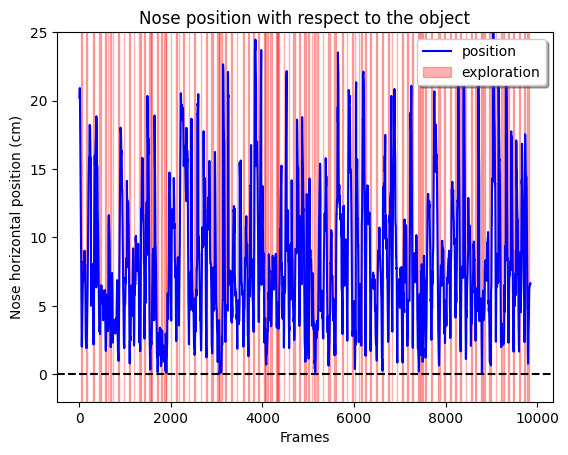

In [47]:
def plot_example_data(X, y):
    # Select data to plot
    position = np.sqrt(X[:,0]**2 + X[:,1]**2).copy()
    exploration = y.copy()

    # Plotting position
    plt.plot(position, label='position', color='blue')

    # Shading exploration regions
    plt.fill_between(range(len(exploration)), -30, 30, where = exploration > 0, label = 'exploration', color='red', alpha=0.3)

    # Adding labels
    plt.xlabel('Frames')
    plt.ylabel('Nose horizontal position (cm)')
    plt.legend(loc='upper right', fancybox=True, shadow=True, framealpha=1.0)
    plt.title('Nose position with respect to the object')
    plt.axhline(y=0, color='black', linestyle='--')

    # Zoom in on some frames
    # plt.xlim((1000, 2500))
    plt.ylim((-2, 25))

    plt.show()

# Plot the data before training
plot_example_data(X_test, y_test)

Lets get some tools ready for model training:

- Early stopping
- Scheduled learning rate

In [48]:
# Set the number of neurons in each layer
param_0 = 128
param_H1 = 96
param_H2 = 48
param_H3 = 24
param_H4 = 12

batch_size = 32 # Set the batch size
lr = 0.0002 # Set the initial learning rate
epochs = 100 # Set the training epochs
patience = 16 # Set the wait for the early stopping mechanism

In [49]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
    mode='min',
    verbose=1,
)

# Define a learning rate schedule function
initial_lr = lr # Set the initial lr
def lr_schedule(epoch, lr): # Define a learning rate schedule function
    initial_lr = lr  # Initial learning rate
    decay_factor = 0.8  # Learning rate decay factor
    decay_epochs = 8   # Number of epochs after which to decay the learning rate

    # Calculate the new learning rate
    lr = initial_lr * (decay_factor ** (epoch // decay_epochs))

    return lr

# Define the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [50]:
def plot_history(model, model_name):
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(model.history['loss'], label='Training loss')
    plt.plot(model.history['val_loss'], label='Validation loss')
    plt.plot(model.history['accuracy'], label='Training accuracy')
    plt.plot(model.history['val_accuracy'], label='Validation accuracy')
    
    plt.title(f'Training of model {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('%')
    plt.legend()
    plt.show()

In [51]:
def evaluate(X, y, model):
    
    # Evaluate the model on the testing set
    y_pred = model.predict(X)
    y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
    
    if isinstance(y, tf.Tensor):
        y = y.numpy()
    y_binary = (y > 0.5).astype(int) # Convert average labels to binary labels
    
    accuracy = accuracy_score(y_binary, y_pred_binary)
    precision = precision_score(y_binary, y_pred_binary, average = 'weighted')
    recall = recall_score(y_binary, y_pred_binary, average = 'weighted')
    f1 = f1_score(y_binary, y_pred_binary, average = 'weighted')
    
    print(classification_report(y_binary, y_pred_binary))
    
    return accuracy, precision, recall, f1

def evaluate_continuous(X, y, model):
    # Ensure X and y are on the same device
    if isinstance(X, tf.Tensor):
        if '/GPU:' in X.device:
            y = tf.convert_to_tensor(y)
            y = tf.identity(y)

    # Evaluate the model on the testing set
    y_pred = model.predict(X)

    # Convert y and y_pred to numpy arrays if they are tensors
    if isinstance(y_pred, tf.Tensor):
        y_pred = y_pred.numpy()
    
    if isinstance(y, tf.Tensor):
        y = y.numpy()
    
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    return mse, mae, r2

Now we train the first model

In [52]:
# Build a simple neural network
model_simple = tf.keras.Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(param_0, activation='relu'),
    Dropout(0.4),
    Dense(param_H1, activation='relu'),
    Dropout(0.3),
    Dense(param_H2, activation='relu'),
    Dropout(0.2),
    Dense(param_H3, activation='relu'),
    Dropout(0.1),
    Dense(param_H4, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_simple.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
                     loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
model_simple.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               1664      
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 96)                12384     
                                                                 
 dropout_13 (Dropout)        (None, 96)                0         
                                                                 
 dense_10 (Dense)            (None, 48)                4656      
                                                                 
 dropout_14 (Dropout)        (None, 48)                0         
                                                                 
 dense_11 (Dense)            (None, 24)               

In [54]:
# Train the model
history_simple = model_simple.fit(X_train, y_train,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  validation_data=(X_val, y_val),
                                  callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
1406/1406 [==============================] - 10s 7ms/step - loss: 0.3215 - accuracy: 0.7116 - val_loss: 0.1887 - val_accuracy: 0.8160 - lr: 2.0000e-04
Epoch 2/100
1406/1406 [==============================] - 8s 6ms/step - loss: 0.2110 - accuracy: 0.7767 - val_loss: 0.1534 - val_accuracy: 0.8259 - lr: 2.0000e-04
Epoch 3/100
1406/1406 [==============================] - 8s 6ms/step - loss: 0.1747 - accuracy: 0.7900 - val_loss: 0.1476 - val_accuracy: 0.8272 - lr: 2.0000e-04
Epoch 4/100
1406/1406 [==============================] - 8s 6ms/step - loss: 0.1610 - accuracy: 0.7942 - val_loss: 0.1460 - val_accuracy: 0.8273 - lr: 2.0000e-04
Epoch 5/100
1406/1406 [==============================] - 8s 6ms/step - loss: 0.1534 - accuracy: 0.7965 - val_loss: 0.1387 - val_accuracy: 0.8296 - lr: 2.0000e-04
Epoch 6/100
1406/1406 [==============================] - 8s 6ms/step - loss: 0.1477 - accuracy: 0.7989 - val_loss: 0.1350 - val_accuracy: 0.8306 - lr: 2.0000e-04
Epoch 7/100
1406/1406 [====

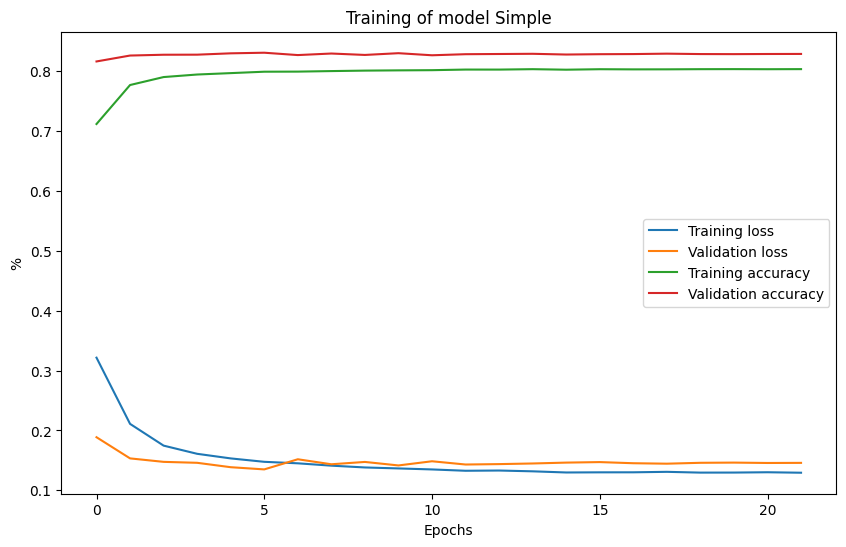

In [55]:
# Plot the training and validation loss
plot_history(history_simple, "Simple")

In [56]:
# Calculate accuracy and precision of the model
accuracy_simple, precision_simple, recall_simple, f1_simple = evaluate(X_test, y_test, model_simple)
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")

mse_simple, mae_simple, r2_simple = evaluate_continuous(X_test, y_test, model_simple)
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")

308/308 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      8592
           1       0.73      0.81      0.77      1263

    accuracy                           0.94      9855
   macro avg       0.85      0.88      0.87      9855
weighted avg       0.94      0.94      0.94      9855

Accuracy = 0.9372, Precision = 0.9406, Recall = 0.9372, F1 Score = 0.9386 -> simple
308/308 [==============================] - 0s 2ms/step
MSE = 0.0343, MAE = 0.0790, R-squared = 0.6565 -> simple


In [57]:
# Save the model
model_simple.save(os.path.join(STORM_folder, f'simple/model_simple_{start_time.date()}.keras'))

Lets move onto training a Recursive Network (that can see sequences)

In [58]:
frames = 7

# Define the LSTM model
model_wide = tf.keras.Sequential([
    Input(shape=(frames, X_train_wide.shape[2])),
    LSTM(param_0, return_sequences=True),
    Dropout(0.4),
    LSTM(param_H1, return_sequences=True),
    Dropout(0.3),
    LSTM(param_H2, return_sequences=True),
    Dropout(0.2),
    LSTM(param_H3, return_sequences=True),
    Dropout(0.1),
    LSTM(param_H4),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_wide.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
                     loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
model_wide.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 7, 128)            72192     
                                                                 
 dropout_16 (Dropout)        (None, 7, 128)            0         
                                                                 
 lstm_11 (LSTM)              (None, 7, 96)             86400     
                                                                 
 dropout_17 (Dropout)        (None, 7, 96)             0         
                                                                 
 lstm_12 (LSTM)              (None, 7, 48)             27840     
                                                                 
 dropout_18 (Dropout)        (None, 7, 48)             0         
                                                                 
 lstm_13 (LSTM)              (None, 7, 24)            

In [60]:
# Train the model
history_wide = model_wide.fit(X_train_wide, y_train,
                              epochs = epochs,
                              batch_size = batch_size,
                              validation_data=(X_val_wide, y_val),
                              callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
1406/1406 [==============================] - 30s 19ms/step - loss: 0.2070 - accuracy: 0.7830 - val_loss: 0.1420 - val_accuracy: 0.8267 - lr: 2.0000e-04
Epoch 2/100
1406/1406 [==============================] - 25s 18ms/step - loss: 0.1302 - accuracy: 0.8012 - val_loss: 0.1374 - val_accuracy: 0.8280 - lr: 2.0000e-04
Epoch 3/100
1406/1406 [==============================] - 25s 18ms/step - loss: 0.1173 - accuracy: 0.8045 - val_loss: 0.1284 - val_accuracy: 0.8299 - lr: 2.0000e-04
Epoch 4/100
1406/1406 [==============================] - 25s 18ms/step - loss: 0.1122 - accuracy: 0.8049 - val_loss: 0.1274 - val_accuracy: 0.8307 - lr: 2.0000e-04
Epoch 5/100
1406/1406 [==============================] - 25s 18ms/step - loss: 0.1095 - accuracy: 0.8054 - val_loss: 0.1226 - val_accuracy: 0.8301 - lr: 2.0000e-04
Epoch 6/100
1406/1406 [==============================] - 25s 17ms/step - loss: 0.1067 - accuracy: 0.8057 - val_loss: 0.1289 - val_accuracy: 0.8290 - lr: 2.0000e-04
Epoch 7/100
1406

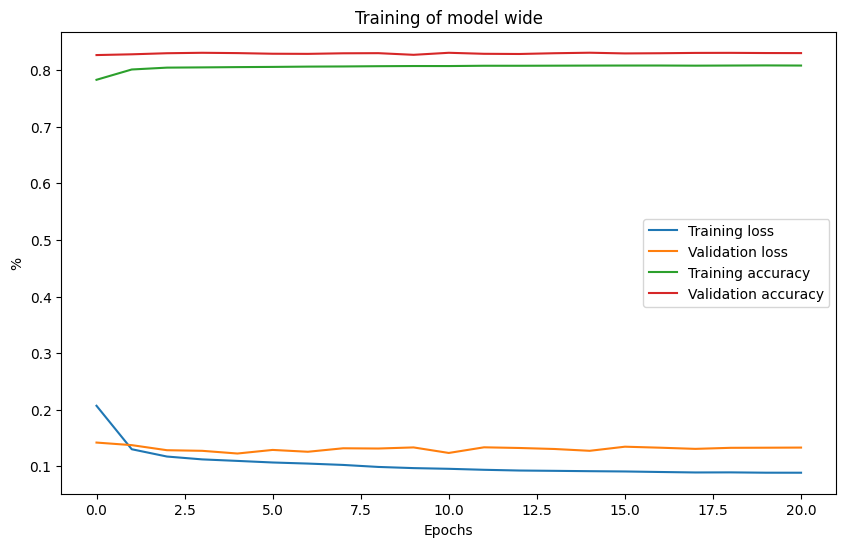

In [61]:
# Plot the training and validation loss
plot_history(history_wide, "wide")

In [62]:
# Calculate accuracy and precision of the model
accuracy_wide, precision_wide, recall_wide, f1_wide = evaluate(X_test_wide, y_test, model_wide)
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")

mse_wide, mae_wide, r2_wide = evaluate_continuous(X_test_wide, y_test, model_wide)
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")

308/308 [==============================] - 3s 7ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8592
           1       0.78      0.83      0.80      1263

    accuracy                           0.95      9855
   macro avg       0.88      0.90      0.89      9855
weighted avg       0.95      0.95      0.95      9855

Accuracy = 0.9475, Precision = 0.9491, Recall = 0.9475, F1 Score = 0.9482 -> wide
308/308 [==============================] - 2s 7ms/step
MSE = 0.0276, MAE = 0.0603, R-squared = 0.7236 -> wide


In [63]:
# Save the model
model_wide.save(os.path.join(STORM_folder, f'wide/model_wide_{start_time.date()}.keras'))

In [64]:
# Define the sequential LSTM model
model_seq = tf.keras.Sequential([
    Input(shape=(frames, X_train_wide.shape[2])),
    Bidirectional(LSTM(param_0, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(param_H1, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(param_H2, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(param_H3, return_sequences=True)),
    Dropout(0.1),
    Bidirectional(LSTM(param_H4, return_sequences=True)),
    Lambda(lambda x: x[:, 3, :]),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_seq.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
                     loss='binary_crossentropy', metrics=['accuracy'])

In [65]:
model_seq.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 7, 256)           144384    
 nal)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 7, 256)            0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 7, 192)           271104    
 nal)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 7, 192)            0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 7, 96)            92544     
 nal)                                                            
                                                      

In [66]:
# Train the model
history_seq = model_seq.fit(X_train_wide, y_train,
                              epochs = epochs,
                              batch_size = batch_size,
                              validation_data=(X_val_wide, y_val),
                              callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
1406/1406 [==============================] - 53s 32ms/step - loss: 0.1696 - accuracy: 0.7913 - val_loss: 0.1411 - val_accuracy: 0.8252 - lr: 2.0000e-04
Epoch 2/100
1406/1406 [==============================] - 42s 30ms/step - loss: 0.1229 - accuracy: 0.8027 - val_loss: 0.1364 - val_accuracy: 0.8262 - lr: 2.0000e-04
Epoch 3/100
1406/1406 [==============================] - 42s 30ms/step - loss: 0.1141 - accuracy: 0.8042 - val_loss: 0.1435 - val_accuracy: 0.8278 - lr: 2.0000e-04
Epoch 4/100
1406/1406 [==============================] - 42s 30ms/step - loss: 0.1103 - accuracy: 0.8050 - val_loss: 0.1432 - val_accuracy: 0.8261 - lr: 2.0000e-04
Epoch 5/100
1406/1406 [==============================] - 42s 30ms/step - loss: 0.1070 - accuracy: 0.8054 - val_loss: 0.1445 - val_accuracy: 0.8262 - lr: 2.0000e-04
Epoch 6/100
1406/1406 [==============================] - 43s 30ms/step - loss: 0.1035 - accuracy: 0.8063 - val_loss: 0.1331 - val_accuracy: 0.8287 - lr: 2.0000e-04
Epoch 7/100
1406

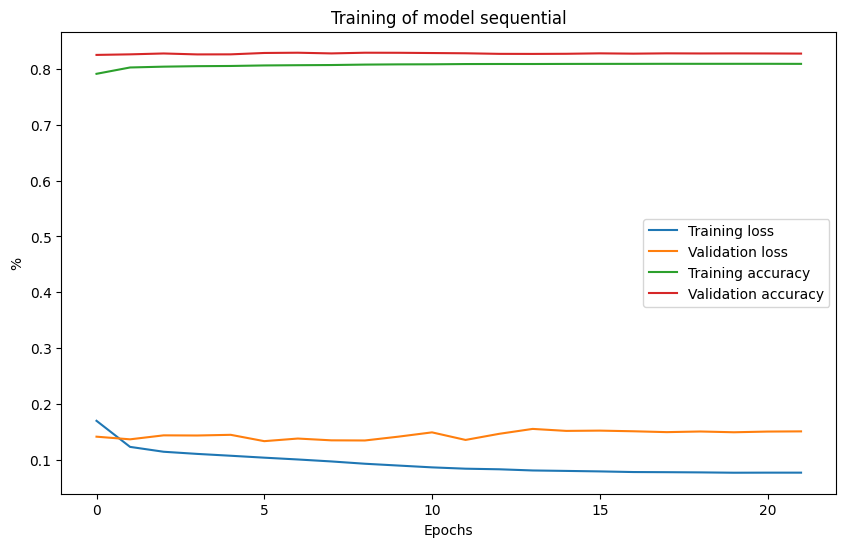

In [67]:
# Plot the training and validation loss
plot_history(history_seq, "sequential")

In [68]:
# Calculate accuracy and precision of the model
accuracy_seq, precision_seq, recall_seq, f1_seq = evaluate(X_test_wide, y_test, model_seq)
print(f"Accuracy = {accuracy_seq:.4f}, Precision = {precision_seq:.4f}, Recall = {recall_seq:.4f}, F1 Score = {f1_seq:.4f} -> seqirectional")

mse_seq, mae_seq, r2_seq = evaluate_continuous(X_test_wide, y_test, model_seq)
print(f"MSE = {mse_seq:.4f}, MAE = {mae_seq:.4f}, R-squared = {r2_seq:.4f} -> seqirectional")

308/308 [==============================] - 5s 10ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      8592
           1       0.75      0.81      0.78      1263

    accuracy                           0.94      9855
   macro avg       0.86      0.89      0.87      9855
weighted avg       0.94      0.94      0.94      9855

Accuracy = 0.9419, Precision = 0.9439, Recall = 0.9419, F1 Score = 0.9427 -> seqirectional
308/308 [==============================] - 3s 9ms/step
MSE = 0.0327, MAE = 0.0608, R-squared = 0.6728 -> seqirectional


In [69]:
# Save the model
model_seq.save(os.path.join(STORM_folder, f'seq/model_seq_{start_time.date()}.keras'))

Lets also train a Random Forest model

In [70]:
# We train a RF model with the same data
if not make_discrete:
    y_train = (y_train > 0.5).astype(int)

# Create the Random Forest model (and set the number of estimators (decision trees))
RF_model = RandomForestClassifier(n_estimators = 24, max_depth = 12)

# Train the MultiOutputClassifier with your data
RF_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=24)

In [71]:
# Calculate accuracy and precision of the model
accuracy_RF, precision_RF, recall_RF, f1_RF = evaluate(X_test, y_test, RF_model)
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f} -> RF")

mse_RF, mae_RF, r2_RF = evaluate_continuous(X_test, y_test, RF_model)
print(f"MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      8592
           1       0.73      0.78      0.76      1263

    accuracy                           0.94      9855
   macro avg       0.85      0.87      0.86      9855
weighted avg       0.94      0.94      0.94      9855

Accuracy = 0.9356, Precision = 0.9376, Recall = 0.9356, F1 Score = 0.9365 -> RF
MSE = 0.0529, MAE = 0.0683, R-squared = 0.4697 -> RF


In [72]:
# Save the model
joblib.dump(RF_model, os.path.join(STORM_folder, f'RF/model_RF_{start_time.date()}.pkl'))

['C:/Users/dhers/Desktop\\STORM/models\\RF/model_RF_2024-11-07.pkl']

In [73]:
# Get the end time
end_time = datetime.datetime.now()

# Calculate elapsed time
elapsed_time = end_time - start_time

In [74]:
# Print the model results
print(f"Script execution time: {elapsed_time}).")

print("Evaluate model vs testing data")

print("VS binary average")
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f} -> RF")
print(f"Accuracy = {accuracy_seq:.4f}, Precision = {precision_seq:.4f}, Recall = {recall_seq:.4f}, F1 Score = {f1_seq:.4f} -> sequential")

print("VS continuous average")
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")
print(f"MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")
print(f"MSE = {mse_seq:.4f}, MAE = {mae_seq:.4f}, R-squared = {r2_seq:.4f} -> sequential")

Script execution time: 0:28:11.456063).
Evaluate model vs testing data
VS binary average
Accuracy = 0.9372, Precision = 0.9406, Recall = 0.9372, F1 Score = 0.9386 -> simple
Accuracy = 0.9475, Precision = 0.9491, Recall = 0.9475, F1 Score = 0.9482 -> wide
Accuracy = 0.9356, Precision = 0.9376, Recall = 0.9356, F1 Score = 0.9365 -> RF
Accuracy = 0.9419, Precision = 0.9439, Recall = 0.9419, F1 Score = 0.9427 -> sequential
VS continuous average
MSE = 0.0343, MAE = 0.0790, R-squared = 0.6565 -> simple
MSE = 0.0276, MAE = 0.0603, R-squared = 0.7236 -> wide
MSE = 0.0529, MAE = 0.0683, R-squared = 0.4697 -> RF
MSE = 0.0327, MAE = 0.0608, R-squared = 0.6728 -> sequential


In [75]:
# Lets test the accuracy of a random and zero y_test

y_zeros = y_test - y_test

y_random = np.random.permutation(y_test)
y_random_binary = (y_random > 0.5).astype(int)

y_binary = (y_test > 0.5).astype(int)

In [76]:
# zeros
print(classification_report(y_binary, y_zeros))

accuracy_zeros = accuracy_score(y_binary, y_zeros)
precision_zeros = precision_score(y_binary, y_zeros, average = 'weighted')
recall_zeros = recall_score(y_binary, y_zeros, average = 'weighted')
f1_zeros = f1_score(y_binary, y_zeros, average = 'weighted')
print(f"Accuracy = {accuracy_zeros:.4f}, Precision = {precision_zeros:.4f}, Recall = {recall_zeros:.4f}, F1 Score = {f1_zeros:.4f} -> zeros")

mse_zeros = mean_squared_error(y_test, y_zeros)
mae_zeros = mean_absolute_error(y_test, y_zeros)
r2_zeros = r2_score(y_test, y_zeros)
print(f"MSE = {mse_zeros:.4f}, MAE = {mae_zeros:.4f}, R-squared = {r2_zeros:.4f} -> zeros")

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      8592
           1       0.00      0.00      0.00      1263

    accuracy                           0.87      9855
   macro avg       0.44      0.50      0.47      9855
weighted avg       0.76      0.87      0.81      9855

Accuracy = 0.8718, Precision = 0.7601, Recall = 0.8718, F1 Score = 0.8121 -> zeros
MSE = 0.1175, MAE = 0.1329, R-squared = -0.1768 -> zeros


c:\Users\dhers\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dhers\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dhers\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dhers\anaconda3\env

In [77]:
# random
print(classification_report(y_binary, y_random_binary))

accuracy_random = accuracy_score(y_binary, y_random_binary)
precision_random = precision_score(y_binary, y_random_binary, average = 'weighted')
recall_random = recall_score(y_binary, y_random_binary, average = 'weighted')
f1_random = f1_score(y_binary, y_random_binary, average = 'weighted')
print(f"Accuracy = {accuracy_random:.4f}, Precision = {precision_random:.4f}, Recall = {recall_random:.4f}, F1 Score = {f1_random:.4f} -> random")

mse_random = mean_squared_error(y_test, y_random)
mae_random = mean_absolute_error(y_test, y_random)
r2_random = r2_score(y_test, y_random)
print(f"MSE = {mse_random:.4f}, MAE = {mae_random:.4f}, R-squared = {r2_random:.4f} -> random")

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      8592
           1       0.13      0.13      0.13      1263

    accuracy                           0.78      9855
   macro avg       0.50      0.50      0.50      9855
weighted avg       0.78      0.78      0.78      9855

Accuracy = 0.7770, Precision = 0.7770, Recall = 0.7770, F1 Score = 0.7770 -> random
MSE = 0.1994, MAE = 0.2285, R-squared = -0.9973 -> random


In [78]:
print("Evaluate model vs testing data")

print("VS binary average")
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f} -> RF")
print(f"Accuracy = {accuracy_seq:.4f}, Precision = {precision_seq:.4f}, Recall = {recall_seq:.4f}, F1 Score = {f1_seq:.4f} -> sequential")
print(f"Accuracy = {accuracy_zeros:.4f}, Precision = {precision_zeros:.4f}, Recall = {recall_zeros:.4f}, F1 Score = {f1_zeros:.4f} -> zeros")
print(f"Accuracy = {accuracy_random:.4f}, Precision = {precision_random:.4f}, Recall = {recall_random:.4f}, F1 Score = {f1_random:.4f} -> random")

print("VS continuous average")
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")
print(f"MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")
print(f"MSE = {mse_seq:.4f}, MAE = {mae_seq:.4f}, R-squared = {r2_seq:.4f} -> sequential")
print(f"MSE = {mse_zeros:.4f}, MAE = {mae_zeros:.4f}, R-squared = {r2_zeros:.4f} -> zeros")
print(f"MSE = {mse_random:.4f}, MAE = {mae_random:.4f}, R-squared = {r2_random:.4f} -> random")

Evaluate model vs testing data
VS binary average
Accuracy = 0.9372, Precision = 0.9406, Recall = 0.9372, F1 Score = 0.9386 -> simple
Accuracy = 0.9475, Precision = 0.9491, Recall = 0.9475, F1 Score = 0.9482 -> wide
Accuracy = 0.9356, Precision = 0.9376, Recall = 0.9356, F1 Score = 0.9365 -> RF
Accuracy = 0.9419, Precision = 0.9439, Recall = 0.9419, F1 Score = 0.9427 -> sequential
Accuracy = 0.8718, Precision = 0.7601, Recall = 0.8718, F1 Score = 0.8121 -> zeros
Accuracy = 0.7770, Precision = 0.7770, Recall = 0.7770, F1 Score = 0.7770 -> random
VS continuous average
MSE = 0.0343, MAE = 0.0790, R-squared = 0.6565 -> simple
MSE = 0.0276, MAE = 0.0603, R-squared = 0.7236 -> wide
MSE = 0.0529, MAE = 0.0683, R-squared = 0.4697 -> RF
MSE = 0.0327, MAE = 0.0608, R-squared = 0.6728 -> sequential
MSE = 0.1175, MAE = 0.1329, R-squared = -0.1768 -> zeros
MSE = 0.1994, MAE = 0.2285, R-squared = -0.9973 -> random
